C:\Users\zhang\AppData\Local\Temp\ipykernel_8492\1860220691.py:30: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:264.)
  return torch.tensor(X), torch.tensor(y)
d:\miniconda\envs\py3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0: train RMSE 226.2426, test RMSE 425.4752
Epoch 100: train RMSE 179.6295, test RMSE 376.6336
Epoch 200: train RMSE 144.2437, test RMSE 338.0703
Epoch 300: train RMSE 114.8427, test RMSE 303.5809
Epoch 400: train RMSE 92.3887, test RMSE 273.1548
Epoch 500: train RMSE 70.2607, test RMSE 240.2209
Epoch 600: train RMSE 55.5851, test RMSE 212.8457
Epoch 700: train RMSE 44.5889, test RMSE 188.6628
Epoch 800: train RMSE 37.1261, test RMSE 167.7965
Epoch 900: train RMSE 31.8539, test RMSE 149.2716
Epoch 1000: train RMSE 27.9820, test RMSE 133.8515
Epoch 1100: train RMSE 25.5915, test RMSE 120.9271
Epoch 1200: train RMSE 23.5897, test RMSE 110.0786
Epoch 1300: train RMSE 22.7980, test RMSE 102.3912
Epoch 1400: train RMSE 21.6408, test RMSE 94.9922
Epoch 1500: train RMSE 21.2050, test RMSE 90.1998
Epoch 1600: train RMSE 21.4369, test RMSE 86.6212
Epoch 1700: train RMSE 20.0588, test RMSE 82.9872
Epoch 1800: train RMSE 19.9610, test RMSE 81.9268
Epoch 1900: train RMSE 20.0782, test RMSE 78

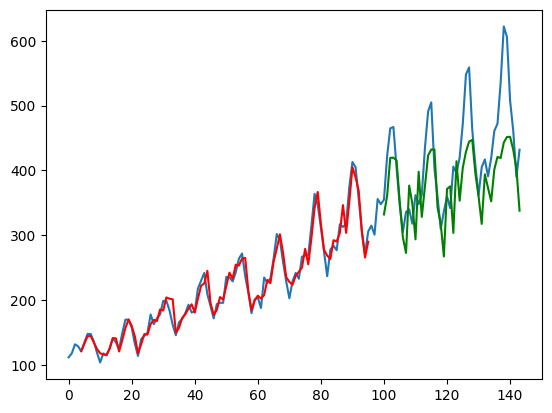

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data

df = pd.read_csv('./datasets/airline-passengers.csv')
timeseries = df[["Passengers"]].values.astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

lookback = 4
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)

class AirModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x

model = AirModel()
optimizer = optim.Adam(model.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=True, batch_size=8)

n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))

with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries)
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()